#### Import everything you need

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [70]:
#### Ring a bell!

In [79]:
def inform_exit():
    
    os.system('say "Training process is completed"')

In [127]:
inform_exit()

#### Load Data

In [126]:
def Load_Text_Data(file_path='../trump_tweet_data_archive'):
    """
    Reads the input data.

    :param file_path: (Optional) Position of the txt file in the local system.

    :return: tweets: all input tweets and unique_characters: unique single characters of the input data.
    """
    tweets = []
    for year in range(2009, 2018):
        with open(f'../trump_tweet_data_archive/condensed_{year}.json', ) as condensed:
            data = json.load(condensed)
            for text in range(len(data)):
                text = data[text]['text']
                text += '±'
                tweets.append( text )
    all_chars = ''
    for tweet in tweets:
        all_chars += tweet
    unique_characters = list(set(all_chars))
    return tweets, unique_characters

#### Characters to Index transformation

In [8]:
def Char_to_Ind(chars_list, unique_chars):
    """
    Maps the original characters to integers.

    :param chars_list: The list of characters to be encoded into integers.
    :param unique_chars: The set of unique characters available.

    :return: A list of integers that correspond to the characters.
    """

    encoded_characters = []

    for char in chars_list:
        for index, letter in enumerate(unique_chars):

            if char == letter:

                encoded_characters.append(index)

    return encoded_characters

#### Index to Char transformation

In [9]:
def Ind_to_Char(one_hot_representation, unique_chars_list):
    """
    Maps a list of integers to their corresponding characters,

    :param one_hot_representation: A list of one_hot representations to be transformed to their correspoding characters.
    :param unique_chars_list: The list of unique characters.

    :return: The actual character sequence.
    """

    actual_character_sequence = []

    for i in range(one_hot_representation.shape[1]):

        letter_pos = np.where(one_hot_representation[:,i] == 1.0)[0][0]
        actual_character_sequence.append(unique_chars_list[letter_pos])

    return actual_character_sequence

In [10]:
def create_one_hot_endoding(x, K):
    """
    Creates the one hot encoding representation of an array.


    :param x: The array that we wish to map in an one-hot representation.
    :param K: The number of distinct classes.

    :return: One hot representation of this number.
    """

    x_encoded = np.zeros((K, len(x)))
    for index, elem in enumerate(x):

        x_encoded[elem, index] = 1.0

    return x_encoded

#### Softmax

In [11]:
def softmax(X, theta=1.0, axis=None):
    """
    Softmax over numpy rows and columns, taking care for overflow cases
    Many thanks to https://nolanbconaway.github.io/blog/2017/softmax-numpy
    Usage: Softmax over rows-> axis =0, softmax over columns ->axis =1

    :param X: ND-Array. Probably should be floats.
    :param theta: float parameter, used as a multiplier prior to exponentiation. Default = 1.0
    :param axis (optional): axis to compute values along. Default is the first non-singleton axis.

    :return: An array the same size as X. The result will sum to 1 along the specified axis
    """

    # make X at least 2d
    y = np.atleast_2d(X)

    # find axis
    if axis is None:
        axis = next(j[0] for j in enumerate(y.shape) if j[1] > 1)
    # multiply y against the theta parameter,
    y = y * float(theta)

    # subtract the max for numerical stability
    y = y - np.expand_dims(np.max(y, axis=axis), axis)

    # exponentiate y
    y = np.exp(y)

    # take the sum along the specified axis
    ax_sum = np.expand_dims(np.sum(y, axis=axis), axis)

    # finally: divide elementwise
    p = y / ax_sum

    # flatten if X was 1D
    if len(X.shape) == 1: p = p.flatten()

    return p

In [93]:
def visualize_smoothed_loss(smoothed_loss, display=False, title=None, save_name=None, save_path='../figures/'):
    """
        Visualization and saving the loss of the network.

        :param smoothed_loss: The smooth loss of the RNN network.
        :param display: (Optional) Boolean, set to True for displaying the loss evolution plot.
        :param title: (Optional) Title of the plot.
        :param save_name: (Optional) name of the file to save the plot.
        :param save_path: (Optional) Path of the folder to save the plot in your local computer.

        :return: None

        """

    if title is not None:
        plt.title(title)

    plt.plot(smoothed_loss)

    if save_name is not None:
        if save_path[-1] != '/':
            save_path += '/'
        plt.savefig(save_path + save_name + '.png')

    if display:
        plt.show()

    plt.clf()

### Vanilla Recurrent Neural Network Class

In [119]:
class RNN:
    """
    Recurrent Neural Network object
    """

    def __init__(self, m, K, eta, seq_length, std, epsilon=1e-10):
        """
        Initial setting of the RNN.

        :param m: Dimensionality of the hidden state.
        :param K: Number of unique classes to identify.
        :param eta: The learning rate of the training process.
        :param seq_length: The length of the input sequence.
        :param std: the variance of the normal distribution that initializes the weight matrices.
        :param epsilon: epsilon parameter of ada-grad.
        """

        self.m = m
        self.K = K
        self.eta = eta
        self.seq_length = seq_length
        self.std = std
        self.epsilon = epsilon

    def init_weights(self):
        """
        Initializes the weights and bias matrices
        """

        U = np.random.normal(0, self.std, size=(self.m, self.K))
        W = np.random.normal(0, self.std, size=(self.m, self.m))
        V = np.random.normal(0, self.std, size=(self.K, self.m))

        b = np.zeros((self.m, 1))
        c = np.zeros((self.K, 1))

        return [W, U, b, V, c]

    def synthesize_sequence(self, h0, x0, weight_parameters, text_length):
        """
        Synthesizes a sequence of characters under the RNN values.

        :param self: The RNN.
        :param h0: Hidden state at time 0.
        :param x0: First (dummy) input vector of the RNN.
        :param weight_parameters: The weighst and biases of the RNN, which are:
            :param W: Hidden-to-Hidden weight matrix.
            :param U: Input-to-Hidden weight matrix.
            :param b: Bias vector of the hidden layer.
            :param V: Hidden-to-Output weight matrix.
            :param c: Bias vector of the output layer.
        :param text_length: The length of the text you wish to generate

        :return: Synthesized text through.
        """

        W, U, b, V, c = weight_parameters
        Y = np.zeros(shape=(x0.shape[0], text_length))

        alpha = np.dot(W, h0) + np.dot(U, np.expand_dims(x0[:,0], axis=1)) + b
        h = np.tanh(alpha)
        o = np.dot(V, h) + c
        p = softmax(o)

        # Compute the cumulative sum of p and draw a random sample from [0,1)
        cumulative_sum = np.cumsum(p)
        draw_number = np.random.sample()

        # Find the element that corresponds to this random sample
        pos = np.where(cumulative_sum > draw_number)[0][0]

        # Create one-hot representation of the found position
        Y[pos, 0] = 1.0

        h0 = np.copy(h)
        x0 = np.expand_dims(np.copy(Y[:,0]), axis=1)

        for index in range(1, text_length):

            alpha = np.dot(W, h0) + np.dot(U, x0) + b
            h = np.tanh(alpha)
            o = np.dot(V, h) + c
            p = softmax(o)

            # Compute the cumulative sum of p and draw a random sample from [0,1)
            cumulative_sum = np.cumsum(p)
            draw_number = np.random.sample()

            # Find the element that corresponds to this random sample
            pos = np.where(cumulative_sum > draw_number)[0][0]

            # Create one-hot representation of the found position
            Y[pos, index] = 1.0

            h0 = np.copy(h)
            x0 = np.expand_dims(np.copy(Y[:, index]), axis=1)

        return Y

    def ComputeLoss(self, input_sequence, Y, weight_parameters):
        """
        Computes the cross-entropy loss of the RNN.

        :param input_sequence: The input sequence.
        :param weight_parameters: Weights and matrices of the RNN, which in particularly are:
            :param W: Hidden-to-Hidden weight matrix.
            :param U: Input-to-Hidden weight matrix.
            :param b: Bias vector of the hidden layer.
            :param V: Hidden-to-Output weight matrix.
            :param c: Bias vector of the output layer.

        :return: Cross entropy loss (divergence between the predictions and the true output)
        """

        p = self.ForwardPass(input_sequence, weight_parameters)[2]

        cross_entropy_loss = -np.log(np.diag(np.dot(Y.T, p))).sum()

        return cross_entropy_loss

    def ForwardPass(self, input_sequence, weight_parameters, h0 = None):
        """
        Evaluates the predictions that the RNN does in an input character sequence.

        :param input_sequence: The one-hot representation of the input sequence.
        :param weight_parameters: The weights and biases of the network, which are:
            :param W: Hidden-to-Hidden weight matrix.
            :param U: Input-to-Hidden weight matrix.
            :param b: Bias vector of the hidden layer.
            :param V: Hidden-to-Output weight matrix.
            :param c: Bias vector of the output layer.
        :param h0: Initial hidden state value.

        :return: The predicted character sequence based on the input one.
        """

        W, U, b, V, c = weight_parameters

        p = np.zeros(input_sequence.shape)
        if h0 is None:
            h_list = [np.zeros((self.m, 1))]
        else:
            h_list = [h0]

        a_list = []

        for index in range(0, input_sequence.shape[1]):

            alpha = np.dot(W, h_list[-1]) + np.dot(U, np.expand_dims(input_sequence[:,index], axis=1)) + b
            a_list.append(alpha)
            h = np.tanh(alpha)
            h_list.append(h)
            o = np.dot(V, h) + c
            p[:, index] = softmax(o).reshape(p.shape[0],)

        return a_list, h_list[1:], p

    def BackwardPass(self, x, Y, p, W, V, a, h, with_clipping=True):
        """
        Computes the gradient updates of the network's weight and bias matrices based on the divergence between the
        prediction and the true output.

        :param x: Input data to the network.
        :param p: Predictions of the network.
        :param Y: One-hot representation of the correct sequence.
        :param W: Hidden-to-Hidden weight matrix.
        :param V: Hidden-to-Output weight matrix.
        :param a: Hidden states before non-linearity.
        :param h: Hidden states of the network at each time step.
        :param with_clipping: (Optional) Set to False for not clipping in he gradients

        :return:  Gradient updates.
        """

        # grad_W, grad_U, grad_b, grad_V, grad_c = \
        #     np.zeros(W.shape), np.zeros((W.shape[0], x.shape[1])), np.zeros((W.shape[0], 1)), np.zeros(V), np.zeros((x.shape[0], 1))

        # Computing the gradients for the last time step

        grad_c = np.expand_dims((p[:, x.shape[1]- 1] - Y[:, x.shape[1]- 1]).T, axis=1)
        grad_V = np.dot(grad_c, h[-1].T)

        grad_h = np.dot(V.T, grad_c)

        grad_b = np.expand_dims(np.dot(grad_h.reshape((grad_h.shape[0],)), np.diag(1 - np.tanh(a[-1].reshape((a[-1].shape[0],))) ** 2)), axis=1)

        grad_W = np.dot(grad_b, h[-2].T)
        grad_U = np.dot(grad_b, np.expand_dims(x[:,-1], axis=0))

        grad_a = grad_b

        for time_step in reversed(range(x.shape[1]- 1)):

            grad_o = np.expand_dims((p[:, time_step] - Y[:, time_step]).T, axis=1)
            grad_V += np.dot(grad_o, np.transpose(h[time_step]))
            grad_c += grad_o

            grad_h = np.dot(V.T, grad_o) + np.dot(grad_a.T, W).T

            grad_a = np.expand_dims(np.dot(grad_h.reshape((grad_h.shape[0],)), np.diag(1 - np.tanh(a[time_step].reshape((a[time_step].shape[0],))) ** 2)), axis=1)

            grad_W += np.dot(grad_a, h[time_step-1].T)
            grad_U += np.dot(grad_a, np.expand_dims(x[:,time_step], axis=1).T)

            grad_b += grad_a

        gradients = [grad_W, grad_U, grad_b, grad_V, grad_c]

        if with_clipping:

            for index, elem in enumerate(gradients):

                gradients[index] = np.maximum(-5, np.minimum(elem, 5))

        return gradients

    def initialize_ada_grad(self, weight_parameters):
        """
        Initializes the ada_grads of the weights parameters.

        :param weight_parameters: The weights and biases of the RNN

        :return: Initialized ada-grad parameters.
        """

        ada_grads = []

        for elem in weight_parameters:

            ada_grads.append(np.zeros(shape=elem.shape))

        return ada_grads

    def ada_grad_update(self, weight_parameters, ada_grads, gradients, eta):
        """
        Conducts one update step of the ada-grants and weights parameters based on the currently estimated gradient updates.

        :param weight_parameters: Weights and biases of the RNN network.
        :param ada_grads: Ada grad parameters.
        :param gradients: Gradient updates of a training step.
        :param eta: Learning rate of the training process.

        :return: Updated weight and ada_grad parameters.
        """

        # Update ada-grads
        for index, elem in enumerate(ada_grads):

            elem += gradients[index] ** 2

        for index, weight_elem in enumerate(weight_parameters):

            weight_elem -= eta * gradients[index] / np.sqrt(ada_grads[index] + self.epsilon)

        return weight_parameters, ada_grads


    def fit(self, X, Y, epoches, unique_characters, verbose=True, with_break=False):
        """
        Comnducts the training pprocess of the RNN nad estimates the model.

        :param X: Input data (one-hot representation).
        :param Y: Treu labels (one-hot representation).
        :param epoches: Number of training epochs.
        :param unique_characters: The unique characters that can be generated from the training process.
        :param verbose: (Optional) Set to False if you do not wish to print synthesized texts during training.
        :param with_break: (Optional) Set to True if you want to break after 100 000 update steps.

        :return: The trained model.
        """

        weight_parameters = self.init_weights()
        gradient_object = Gradients(self)

        # Number of distinct training sequences per epoch
        training_sequences_per_epoch = X.shape[1] - self.seq_length

        ada_grads = self.initialize_ada_grad(weight_parameters)

        for epoch in range(epoches):

            hprev = np.zeros(shape=(self.m, 1))

            if epoch == 0 and verbose:
                synthesized_text = Ind_to_Char(
                    self.synthesize_sequence(h0=hprev, x0=X, weight_parameters=weight_parameters, text_length=200),
                    unique_characters)
                print('---------------------------------------------------------')
                print(f'Synthesized before any update step:')
                print(''.join(synthesized_text))

            for e in range(training_sequences_per_epoch):

                current_update_step = epoch * training_sequences_per_epoch + e

                x = X[:, e:e + self.seq_length]
                y = Y[:, e + 1:e + self.seq_length + 1]

                gradient_updates, hprev = gradient_object.ComputeGradients(x, y, weight_parameters, hprev)

                weight_parameters, ada_grads = self.ada_grad_update(weight_parameters, ada_grads, gradient_updates,
                                                                    eta=self.eta)

                if epoch == 0 and e == 0:
                    smooth_loss_evolution = [self.ComputeLoss(x, y, weight_parameters)]
                    minimum_loss = smooth_loss_evolution[0]

                else:
                    current_loss = 0.999 * smooth_loss_evolution[-1] + 0.001 * self.ComputeLoss(x, y, weight_parameters)
                    smooth_loss_evolution.append(current_loss)
                    if current_loss < minimum_loss:
                        best_weights = weight_parameters
                    best_h_prev = hprev

                if verbose:

                    if len(smooth_loss_evolution) % 1000 == 0 and len(smooth_loss_evolution) > 0:
                        print('---------------------------------------------------------')
                        print(f'Smooth loss at update step no.{current_update_step}: {smooth_loss_evolution[-1]}')

                        # Also generate synthesized text if 500 updates steps have been conducted
                        if len(smooth_loss_evolution) % 10000 == 0 and len(smooth_loss_evolution) > 0:
                            synthesized_text = Ind_to_Char(
                                self.synthesize_sequence(h0=hprev, x0=X, weight_parameters=weight_parameters,
                                                         text_length=200), unique_characters)
                            print('---------------------------------------------------------')
                            print(f'Synthesized text of update step no.{current_update_step}')
                            print(''.join(synthesized_text))

                if with_break and current_update_step == 100000:
                    return best_weights, best_h_prev, smooth_loss_evolution

        return best_weights, best_h_prev, smooth_loss_evolution

### Gradients Class

In [88]:
class Gradients:

    def __init__(self, RNN):
        self.RNN = RNN

    def ComputeGradients(self, X, Y, weight_parameters, hprev, with_clipping=True):
        """
        Computes the analytical gradient updates of the network.
        :param X: Input sequence.
        :param Y: True output
        :param weight_parameters: Weights and bias matrices of the network.
        :param hprev: Initial hidden state to be used in the forward and backwward pass of the RNN.
        :param with_clipping: (Optional) Set ot False if you don't wish to apply clipping in the gradients.

        :return: Gradients updates.
        """

        a_list, h_list, p = self.RNN.ForwardPass(X, weight_parameters, h0=hprev)
        gradients = self.RNN.BackwardPass(X, Y, p, weight_parameters[0], weight_parameters[3], a_list, h_list, with_clipping)

        return gradients, h_list[0]

    def ComputeGradsNumSlow(self, X, Y, weight_parameters, h=1e-4):

        from tqdm import tqdm
        all_grads_num = []

        for index, elem in enumerate(weight_parameters):

            grad_elem = np.zeros(elem.shape)
            # h_prev = np.zeros((W.shape[1], 1))

            for i in tqdm(range(elem.shape[0])):
                for j in range(elem.shape[1]):

                    elem_try = np.copy(elem)
                    elem_try[i, j] -= h
                    all_weights_try = weight_parameters.copy()
                    all_weights_try[index] = elem_try
                    c1 = self.RNN.ComputeLoss(X, Y, weight_parameters=all_weights_try)

                    elem_try = np.copy(elem)
                    elem_try[i, j] += h
                    all_weights_try = weight_parameters.copy()
                    all_weights_try[index] = elem_try
                    c2 = self.RNN.ComputeLoss(X, Y, weight_parameters=all_weights_try)

                    grad_elem[i, j] = (c2-c1) / (2*h)

            all_grads_num.append(grad_elem)

        return all_grads_num

    def check_similarity(self, X, Y, weight_parameters, with_cliping = False):
        """
        Computes and compares the analytical and numerical gradients.

        :param X: Input sequence.
        :param Y: True output
        :param weight_parameters: Weights and bias matrices of the network.
        :param with_cliping: (Optional) Set to True to apply clipping in the gradients

        :return: None.
        """

        analytical_gradients, _ = self.ComputeGradients(X, Y, weight_parameters, hprev=np.zeros(shape=(self.RNN.m, 1)))
        numerical_gradients = self.ComputeGradsNumSlow(X, Y, weight_parameters)

        for weight_index in range(len(analytical_gradients)):
            print('-----------------')
            print(f'Weight parameter no. {weight_index+1}:')

            weight_abs = np.abs(analytical_gradients[weight_index] - numerical_gradients[weight_index])

            weight_nominator = np.average(weight_abs)

            grad_weight_abs = np.absolute(analytical_gradients[weight_index])
            grad_weight_num_abs = np.absolute(numerical_gradients[weight_index])

            sum_weight = grad_weight_abs + grad_weight_num_abs

            print(f'Deviation between analytical and numerical gradients: {weight_nominator / np.amax(sum_weight)}')

## EXERCISES

### 0.1 Read in the data

In [14]:
book_data, unique_characters = Load_Text_Data()

### 0.2 Set hyper-parameters & initialize the RNN’s parameters

In [46]:
rnn = RNN(m=100, K=len(unique_characters), eta=0.01, seq_length=25, std=0.1)

weight_parameters = rnn.init_weights()

### 0.3 Synthesize text from your randomly initialized RNN

In [50]:
input_sequence = book_data[:rnn.seq_length]

integer_encoding = Char_to_Ind(input_sequence, unique_characters)
input_sequence_one_hot = create_one_hot_endoding(integer_encoding, len(unique_characters))

test = rnn.synthesize_sequence(h0=np.zeros((rnn.m, 1)), x0=input_sequence_one_hot, weight_parameters=weight_parameters, text_length=rnn.seq_length)
test2 = Ind_to_Char(test, unique_characters)
print(''.join(test2))

6}Cf}KL9D qSWzI;)Jv}J"!'A


### 0.4 Implement the forward and backward pass

We vallidate the correct performance of the forward and backward pass by comparing with the numerical gradients

In [65]:
book_data, unique_characters = Load_Text_Data()

rnn_object = RNN(m=5, K=len(unique_characters), eta=0.01, seq_length=25, std=0.01)
gradient_object = Gradients(rnn_object)

weight_parameters = rnn_object.init_weights()

input_sequence = book_data[:rnn_object.seq_length]
integer_encoding = Char_to_Ind(input_sequence, unique_characters)
input_sequence_one_hot = create_one_hot_endoding(integer_encoding, len(unique_characters))

output_sequence = book_data[1:1 + rnn_object.seq_length]
output_encoding = Char_to_Ind(output_sequence, unique_characters)
output_sequence_one_hot = create_one_hot_endoding(output_encoding, len(unique_characters))

Check similarity:

In [66]:
gradient_object.check_similarity(input_sequence_one_hot, output_sequence_one_hot, weight_parameters)

100%|██████████| 80/80 [00:00<00:00, 508.64it/s]

-----------------
Weight parameter no. 1:
Deviation between analytical and numerical gradients: 0.01530391399828311
-----------------
Weight parameter no. 2:
Deviation between analytical and numerical gradients: 9.347829544732643e-11
-----------------
Weight parameter no. 3:
Deviation between analytical and numerical gradients: 6.028087082473465e-10
-----------------
Weight parameter no. 4:
Deviation between analytical and numerical gradients: 8.20341705132328e-10
-----------------
Weight parameter no. 5:
Deviation between analytical and numerical gradients: 6.804348250238339e-11


Done!

### 0.5 Train your RNN using AdaGrad

#### Include a graph of the smooth loss function for a longish training run (at least 2 epochs).

In [128]:
rnn = RNN(m=100, K=len(unique_characters), eta=0.01, seq_length=25, std=0.01)

# Create one-hot data
integer_encoding = Char_to_Ind(book_data, unique_characters)
input_sequence_one_hot = create_one_hot_endoding(integer_encoding, len(unique_characters))
output_sequence_one_hot = create_one_hot_endoding(integer_encoding, len(unique_characters))

weight_parameters, smoothed_loss_evolution, h_prev = rnn.fit(X=input_sequence_one_hot, Y=output_sequence_one_hot, epoches=3, unique_characters=unique_characters, verbose=False)
inform_exit()

Let's plot the smooth loss evolution for 3 epochs

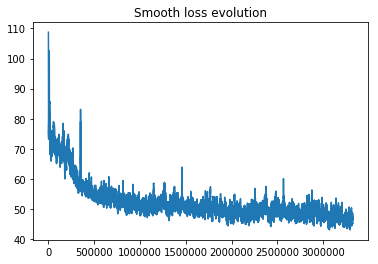

<Figure size 432x288 with 0 Axes>

In [130]:
visualize_smoothed_loss(h_prev, display=True, title='Smooth loss evolution', save_name='sm_loss')

Minimum loss achieved:

In [132]:
min(h_prev)

43.15176033004979

The text generated by the learnt weights parameters is:

In [135]:
synthesized_text = Ind_to_Char(rnn.synthesize_sequence(smoothed_loss_evolution, input_sequence_one_hot, weight_parameters=weight_parameters, text_length=200), unique_characters)
print(''.join(synthesized_text))

y, "Dumbardoon, bestar.  Therey wan.
"Has id, Hagrid, lech sare on they whe whot ever yel me to stundeny betatcotsing.  But a offeder, leet she loture steply to moing must, worly hee liken's dowk It i


####  Show the evolution of the text synthesized by your RNN during training by including a sample of synthesized text (200 characters long) before the first and before every 10,000th update steps when you train for 100,000 update steps.

In [120]:
rnn = RNN(m=100, K=len(unique_characters), eta=0.01, seq_length=25, std=0.01)

# Create one-hot data
integer_encoding = Char_to_Ind(book_data, unique_characters)
input_sequence_one_hot = create_one_hot_endoding(integer_encoding, len(unique_characters))
output_sequence_one_hot = create_one_hot_endoding(integer_encoding, len(unique_characters))

weight_parameters, h_prev, smoothed_loss_evolution = rnn.fit(X=input_sequence_one_hot, Y=output_sequence_one_hot, epoches=3, unique_characters=unique_characters, with_break = True)
inform_exit()

---------------------------------------------------------
Synthesized before any update step:
KmInD;Me(R.DdbzDByXSbb•^"^uSo2)b9,duWe/vmC?eFoeIUNK:4N!ol:"oEj•J6p_UüOG}RF9AupIv.G;?iFtXBF):nPa401WDP0;c,BotwG:G-std,PfOF'pRFfHHJa^zWewfN)hjkFN)'f7QU
7h2rün9GühnBp_HG
UU7E3'PZZVfjX"p^Qq?	'P16p'2ACebTQ
---------------------------------------------------------
Smooth loss at update step no.999: 94.90170425180797
---------------------------------------------------------
Smooth loss at update step no.1999: 85.43124390976648
---------------------------------------------------------
Smooth loss at update step no.2999: 81.27946399189537
---------------------------------------------------------
Smooth loss at update step no.3999: 77.15339622157197
---------------------------------------------------------
Smooth loss at update step no.4999: 73.91599468892989
---------------------------------------------------------
Smooth loss at update step no.5999: 77.47131140824555
----------------------------------

---------------------------------------------------------
Smooth loss at update step no.57999: 65.69446736638152
---------------------------------------------------------
Smooth loss at update step no.58999: 62.688786079324046
---------------------------------------------------------
Smooth loss at update step no.59999: 60.34838670788607
---------------------------------------------------------
Synthesized text of update step no.59999
e vit tha undtre st blof tilt; re Drengad at thea win's somt be,
 hand ay thius in toop to thendly.  Swerat lakce to there kits Qurkiim.  by net Iitn on afing tour inon fo mived tokceuo the rinind to 
---------------------------------------------------------
Smooth loss at update step no.60999: 60.500594894155
---------------------------------------------------------
Smooth loss at update step no.61999: 58.56201967167257
---------------------------------------------------------
Smooth loss at update step no.62999: 60.43890845924481
-----------------------

Smoothed loss evolution:

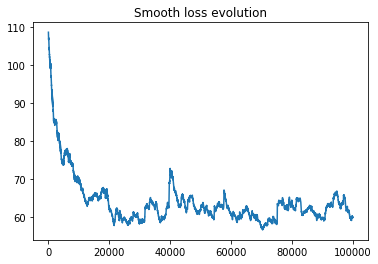

<Figure size 432x288 with 0 Axes>

In [121]:
visualize_smoothed_loss(smoothed_loss_evolution, display=True, title='Smooth loss evolution', save_name='sm_loss_small')

Minimum loss achieved:

In [122]:
min(smoothed_loss_evolution)

56.505959327263554

Synthesized text by best learnt parameters:

In [125]:
synthesized_text = Ind_to_Char(rnn.synthesize_sequence(h_prev, input_sequence_one_hot, weight_parameters=weight_parameters, text_length=1000), unique_characters)
print(''.join(synthesized_text))

erey voo gat Rte towet."
As sposs thtobed hoursss. Weuscieg wit, t poreaned,"s ded, sewone he pimas ap fpaastl, Un! "Roig goot R Poug, Rot hid thea's," sice koucke tabeer ferly.  Tho gail os ofRivga dey pazats on thingsinpint, saced forly nhedney. wrs, thet, thecly out whing thead had Iped yow souct dica of)paaking al Remourilg," hin werly chtole hay re't otton cay.  Hay bid vey, brinkok.
"Yle saim.
?"We fuckint jf am ince pad tovertewest bouve Rist Harry.. Weat licl ubctmettoisiwt. "Yo warlt tis awh miofand in Harry, the seas?" h tamled yes Harly," has hewe'tter, ang te?v dith Leurdy." fat he ppeplaclnd, blit bothen (o keGropsling, foo hiv, cpasllyyapssty'ped Co tice spalfongel. asy'sis the stomKed war! Wpy, pipcevernint Couthe sauthey piig ytonon-d wht und evey ithered dtapgetpyf ove stoteroy inne pot sus'll they apd'd saad on
"Jomt ippey's for yive dari-,"r tA of t eukl?.
"The daed anon hou lea wad?"
""xessin's pay asleyg.  "Oid I'?" cne. .- Weackign, H's saik," sou't phemt, tho kre